In [ ]:
#| default_exp xs

# [IEEE浮点数](https://www.bilibili.com/video/BV1Lx411p7Wn?p=4&vd_source=ba17c91d27a087001a89289fd2c2af49)


一个二进制的浮点数是如下格式的：$1.0101010$

fp16:
<table  width="160">
    <tr>
        <th style="border: 1px solid black;" width="1">S</th>
        <th style="border: 1px solid black;" width="5">EXP(5)</th>
        <th style="border: 1px solid black;" width="10">frac(10)</th>
    </tr>
</table>

fp32:<table  width="320">
    <tr>
        <th style="border: 1px solid black;" width="1">S</th>
        <th style="border: 1px solid black;" width="8">EXP(8)</th>
        <th style="border: 1px solid black;" width="23">frac(23)</th>
    </tr>
</table>

fp64:<table  width="640">
    <tr>
        <th style="border: 1px solid black;" width="1">S</th>
        <th style="border: 1px solid black;" width="11">EXP(11)</th>
        <th style="border: 1px solid black;" width="52">frac(52)</th>
    </tr>
</table>

**一个二进制的浮点数R=$1.0101010$,在计算机的表达是如下格式**
$$R=(-1)^{S}M2^{E}$$

**指数部分需要减掉一个偏移量**
$$E=max(EXP,1)-bias$$
$$bias=2^{EXP.bits-1}-1$$

**小数部分M: 分为normal和denormal两种表示形式：**
$$M=1.frac$$
$$M=0.frac$$ 

| 类型  | EXP(bits) | frac(bits)  | bias | E的范围|精度|最大数值|
| -    |         - |           - |   - | - | - |- | 
| **FP16(half)** |5  | 10 |15  | [-14,15]|1e-7,2^-24 | 2^16|
| **FP32(float)** |8  | 23 |127| [-126,127]|1e-45,2^-149 |  2^128|
| FP64(double) |11  | 52 |1023    |[-1022,1023]|2^-1075 |  2^1024|


**normal,demormal,sepcial value三种表示的总结：**

| 类型  | EXP(bits) | frac范围  | 备注说明 |
| -     |         - |         - |   - |
| normal     |         not 1 and not 0xff |        [1,2) |   - |
| denormal     |         0 |         [0,1) |   非常接近0的数字 |
| inf     |         0xffff |         0 |   - |
| nan     |         0xffff |         非0 |   - |


下面code是把一个binary的浮点数表示(fp16,fp32,fp64),解析成实数的过程。

In [ ]:
import struct,numpy  as np
from enum import Enum
class FloatType(Enum):
    Half =0
    Single =1
    Double =2

#fp16,fp32,fp64
POSITION_BIAS_TABLE={
    FloatType.Half:(5,15),
    FloatType.Single:(8,127),
    FloatType.Double:(11,1023)
}


num=np.float16(0.30321)
typeIndex=FloatType(0)

binary = num.tobytes() #little order
binary_str = ''.join(format(b, '08b') for b in reversed(binary))



#decode
EXP_LEN,bias=POSITION_BIAS_TABLE[typeIndex]

#extract bits
S=int(binary_str[0],2)
EXP=binary_str[1:1+EXP_LEN]
FRAC=binary_str[1+EXP_LEN:]

print(f'S:{S},EXP:{EXP},FRAC:{FRAC}')

int_EXP=int(EXP,2)
#合并denormal和normal对E的计算的情况
E=max(1,int_EXP)-bias
frac_num=sum(int(x)*2**(-p-1)  for p,x in enumerate(FRAC) )
M=1+frac_num if int_EXP!=0 else frac_num
R=(-1)**S *M*2**(E)
R

S:0,EXP:01101,FRAC:0011011010


0.30322265625

# [混合精度的训练](https://www.youtube.com/watch?v=zbBUExOG-To)

训练的时候混合fp16,fp32，保证在不损失accuracy的情况下，大幅提升内存，带宽利用率，降低训练时长。

- weights副本存储为fp32。
- 中间neuron的计算采用fp16，把weight转成fp16
- 计算完成loss，反向传播的grad先放大scale倍，更新的时候再次缩小scale倍.这样可以防止fp16由于精度位数不足造成的精度丢失。
  - 静态scale
  - 动态scale
- batch_norm层采用fp32进行计算

# inference_mode vs no_grad

In [ ]:
#| hide
import torch,torch.nn as nn

没有no_grad干预下，所有的grad都会被计算

In [ ]:
head_model=torch.nn.Linear(2,3,bias=False)
middle_model=torch.nn.Linear(3,4,bias=False)
tail_model=torch.nn.Linear(4,5,bias=False)

def zeros_grad():
    head_model.weight.grad=None
    middle_model.weight.grad=None
    tail_model.weight.grad=None

torch.manual_seed(442)
X=torch.randn(1,2).requires_grad_(True)
y=torch.randn(1,5)

h_out=head_model(X)
m_out=middle_model(h_out)
t_out=tail_model(m_out)
loss=nn.functional.mse_loss(t_out,y)+X.sum()

zeros_grad()
loss.backward()
head_model.weight.grad,middle_model.weight.grad,tail_model.weight.grad,X.grad

(tensor([[ 0.1711, -0.5651],
         [-0.0390,  0.1287],
         [-0.0462,  0.1527]]),
 tensor([[-0.0105,  0.0041,  0.0186],
         [-0.0089,  0.0034,  0.0158],
         [ 0.2840, -0.1099, -0.5040],
         [ 0.1132, -0.0438, -0.2009]]),
 tensor([[-0.3451,  0.2710,  0.4948, -0.2939],
         [ 0.2144, -0.1684, -0.3074,  0.1826],
         [-0.0464,  0.0364,  0.0665, -0.0395],
         [-0.2470,  0.1940,  0.3542, -0.2104],
         [ 0.0766, -0.0601, -0.1098,  0.0652]]),
 tensor([[1.0657, 1.1260]]))

In [ ]:
torch.manual_seed(442)
X=torch.randn(1,2).requires_grad_(True)
y=torch.randn(1,5)

with torch.no_grad():
    h_out=head_model(X)
    m_out=middle_model(h_out)

t_out=tail_model(m_out)
loss=nn.functional.mse_loss(t_out,y)+X.sum()
zeros_grad()

loss.backward()
head_model.weight.grad,middle_model.weight.grad,tail_model.weight.grad,X.grad

(None,
 None,
 tensor([[-0.2113, -0.0627, -0.0777,  0.3986],
         [ 0.2054,  0.0610,  0.0755, -0.3874],
         [-0.0204, -0.0060, -0.0075,  0.0384],
         [-0.2465, -0.0732, -0.0907,  0.4650],
         [ 0.0779,  0.0231,  0.0286, -0.1469]]),
 tensor([[1., 1.]]))

可以看出 no_grad context manager 包围的下的计算，在backward不会参与grad的计算.<font color=red>同时no_grad也切断了输入到它内部的 梯度的传播</font>,注意到 X是没有这一部分的梯度贡献。

In [ ]:
torch.manual_seed(442)
X=torch.randn(1,2).requires_grad_(True)
y=torch.randn(1,5)
h_out=head_model(X)
with torch.inference_mode():
     
    m_out=middle_model(h_out)
    # t_out=tail_model(m_out)

# 报错，因为    
t_out=tail_model(m_out)

loss=nn.functional.mse_loss(t_out,y)+X.sum()
zeros_grad()

loss.backward()
head_model.weight.grad,middle_model.weight.grad,tail_model.weight.grad,X.grad

inference模型是不会有任何和梯度计算有关的中间节点落地报错的，<font color=red>所以及时在这个context manager包围的代码之后，想计算梯度，也是不允许的</font>

# training中注意事项

## avg_loss与smooth_loss


为了对loss进行平滑处理，我们使用一下`滑动平均`的方式处理loss。


$$
\begin{align}
    avgLoss(t)&= \beta  AvgLoss(t-1)+(1-\beta) L_t \\
       &=\beta^2avgLoss(t-2)+\beta(1-\beta) L_{t-1} +(1-\beta) L_t \\
       &=\beta^3avgLoss(t-3)+\beta^2(1-\beta) L_{t-2}+\beta(1-\beta) L_{t-1} +(1-\beta) L_t\\\
       &=\beta^{t-1}(1-\beta) L_{1}....+\beta^2(1-\beta) L_{t-2}+\beta(1-\beta) L_{t-1} +(1-\beta) L_t\\\
\end{align}
$$

而Li的权重之和是：

$$
\sum_{k=1}^{t}(1-\beta)\beta^{k-1} ={1-\beta^t} 
$$


最后是smoothLoss的公式
$$smoothLoss=\frac{avgLoss}{1-\beta^t}$$

可以看到t非常大的时候，smoothLoss==avgLoss，当t=1时候，$smoothLoss=\frac{avgLoss}{1-\beta}$,这就是`偏差修正`。


## Adam与AdamW的区别

- adma,adamW对m,magnitude进行了 `偏差修正`。
- 对于weight decay处理的不同，Adam把$\lambda \theta$作为grad的一部分，把偏差修正后的结果更新参数。而AdamW把wd解耦出来，直接使用$\lambda \theta$更新了参数。


对应的python code
```python
#Adam
dx=g+WD* grad

m = beta1*m + (1-beta1)*dx
v = beta2*v + (1-beta2)*(dx**2)
#偏差修正
mt = m / (1-beta1**t)
vt = v / (1-beta2**t)
x += - learning_rate * mt / (np.sqrt(vt) + eps)

#Adam
x-=WD*x
dx=g

m = beta1*m + (1-beta1)*dx
v = beta2*v + (1-beta2)*(dx**2)
#偏差修正
mt = m / (1-beta1**t)
vt = v / (1-beta2**t)
x += - learning_rate * mt / (np.sqrt(vt) + eps)

```

## [oneCycle Policy](https://sgugger.github.io/the-1cycle-policy.html)

**对于learning rate:**

OneCycle Policy采用动态调整learning rate的方法。整个训练期分为`Cycle期和annihilate期`，lr遵循着先升后降，最后消退的设计原则。在cycle 期lr从初始值 到最高值,用掉一半的cycle周期，另一半cycle期再次回到初始值。annihilate期lr减少到初始值的【百分之一】或者更小。这样设计的原因是：

- 大的lr不仅能加速训练过程，而且有更大的几率跳过那些更加`陡峭的local minumu`，可防止过拟合，在cycle期让模型参数收敛域那些`平坦的local minumu`.
- `annihilate期`使用很小的lr，可以让参数 收敛到`陡峭的local minumu`。

$$totalEpono=oneCycle+annihilate$$
总之，这是一种先粗粒度，然后再细粒度的设计方法。
from fastai.vision.all import *

## [lr的选取](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)

In [ ]:
from fastai.vision.all import *
import torch,torch.nn as nn
from tqdm.auto import tqdm
# path='/Users/zhanggxk/project/paddy/data/train_images'
path=untar_data(URLs.CIFAR)
dls=ImageDataLoaders.from_folder(path,valid_pct=0.2,item_tfms=Resize(32),bs=512)


In [ ]:
# ResNet56
class BasicBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)
    
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return self.linear(out)

通过以下代码与图表可以看到`偏移修正`的作用

<matplotlib.legend.Legend>

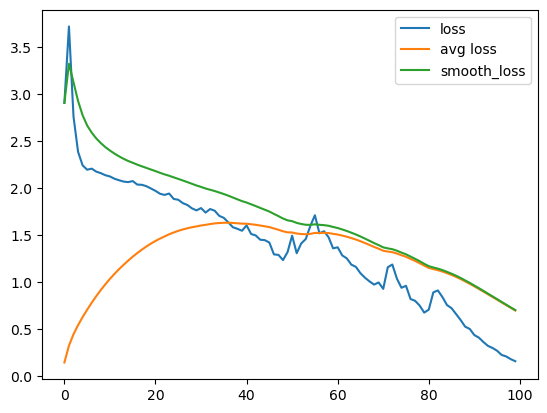

In [ ]:
x,lb=dls.train.one_batch()
model=ResNet([9,9,9],10).to(lb.device)
optimizer=torch.optim.Adam(model.parameters(),1e-2)

lss=[]
for i in tqdm(range(100)):
    y=model(x) 


    logits=y.as_subclass(torch.Tensor)
    labels=lb.as_subclass(torch.Tensor)

    loss=F.cross_entropy(logits,labels);
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    lss.append(loss.item())
    
    
beta=0.95
avg_loss=[0]
smooth_loss=[]
for k in range(len(lss)):
    l=beta*avg_loss[-1]+(1-beta)*lss[k]
    avg_loss.append(l)
    smooth_loss.append(l/(1-beta**(k+1)))
plt.plot(range(len(lss)),lss,label='loss')
avg_loss=avg_loss[1:]
plt.plot(range(len(avg_loss)),avg_loss,label='avg loss')
plt.plot(range(len(smooth_loss)),smooth_loss,label='smooth_loss')
plt.legend()

下面这里我写了一个Bug,废了很长时间才找到问题，你能看出问题来吗？

```python
def find_lr(dls,init_value = 1e-8, final_value=10.,steps=100, beta = 0.98):
    avg_loss,lrs=[0],[]
    best_loss=1e10
    
    mul=(final_value/init_value)**(steps**-1)
    # optimizer.param_groups[0]['lr']=init_value
    x,lb=dls.one_batch()
    for k in tqdm(range(steps)):
        y=model(x)
        logits=y.as_subclass(torch.Tensor)
        labels=lb.as_subclass(torch.Tensor)
        loss=F.cross_entropy(logits,labels);
        loss.backward()
        with torch.no_grad():
            loss=loss.cpu().item()
            
            current_avg_loss=(avg_loss[-1]*beta+loss*(1-beta) )/(1-beta**(k+1))
            print(loss,current_avg_loss,avg_loss[-1]*beta+loss*(1-beta),(1-beta**(k+1)))
            
            avg_loss.append(current_avg_loss)
            lrs.append(optimizer.param_groups[0]['lr'])
            
            if current_avg_loss<best_loss:
                best_loss=current_avg_loss
            if current_avg_loss>4*best_loss:
                pass
        optimizer.step()
        optimizer.zero_grad()
        # optimizer.param_groups[0]['lr']*=mul
        
        
    return avg_loss[1:],lrs
```


In [ ]:
def find_lr(dls,init_value = 1e-8, final_value=10., beta = 0.98):
    smooth_loss,lrs=[],[]
    best_loss=1e10
    avg_loss=0
    steps=len(dls)-1
    
    mul=(final_value/init_value)**(steps**-1)
    optimizer.param_groups[0]['lr']=init_value
    
    for k,(x,lb) in tqdm(enumerate(dls)):
        y=model(x)
        logits=y.as_subclass(torch.Tensor)
        labels=lb.as_subclass(torch.Tensor)
        loss=F.cross_entropy(logits,labels);
        loss.backward()
        with torch.no_grad():
            loss=loss.cpu().item()
            avg_loss=avg_loss*beta+loss*(1-beta)
            
            current_avg_loss=avg_loss/(1-beta**(k+1))
            
            smooth_loss.append(current_avg_loss)
            lrs.append(optimizer.param_groups[0]['lr'])
            
            if current_avg_loss<best_loss:
                best_loss=current_avg_loss
            if current_avg_loss>4*best_loss:
                pass
        optimizer.step()
        optimizer.zero_grad()
        optimizer.param_groups[0]['lr']*=mul
        
        
    return smooth_loss,lrs

model=ResNet([9,9,9],10).to(lb.device)
optimizer=torch.optim.Adam(model.parameters(),1e-2)
smooth_loss,lrs=find_lr(dls.train,init_value = 1e-5, final_value=1)

0it [00:00, ?it/s]

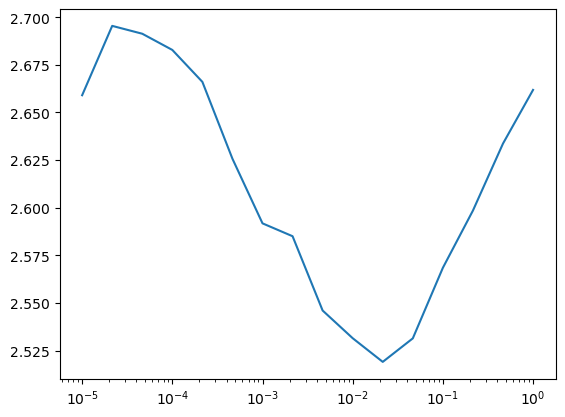

In [ ]:
plt.plot(lrs,smooth_loss)
plt.xscale('log')

## Optimizer对象

我们知道一个最简单的optimzer可以定义成如下
```python
model=nn.Linear(3,2)
optimizer=torch.optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)
```
- params参数是个迭代器，迭代返回要优化的参数,例如类型-> `List[Dict[str,Any]]`
- lr,momentum是优化器必要的参数
- 这样设置的只有一个组，通过`param_groups[0]['lr']`可以访问上面的args.

**但我们也可以定义如下的迭代器，迭代返回是一个dict，dict的key必须对定于构造器的args**.

**param_groups[0],param_groups[1]可以分组访问优化器**

In [ ]:
import torch,torch.nn as nn

optimizer=torch.optim.SGD([
    {'lr':1e-3,'momentum':0.9,'params':model1.parameters()},
    {'lr':1e-4,'momentum':0.3,'params':model2.parameters()},
])
optimizer.param_groups[1]

# matplotlib

logscale的图怎么看？

线性等分的坐标在logscale上`相邻点之间距离`区别很大.

<matplotlib.legend.Legend>

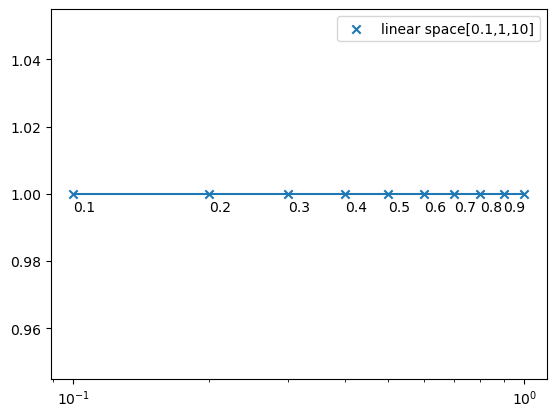

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

xx=10**np.linspace(-1,0,10)
yy=[1]*len(xx)
# plt.xscale('log')
plt.semilogx()
plt.plot(xx,yy)

xx=np.linspace(0.1,1,10)
plt.scatter(xx,yy,marker='x',label='linear space[0.1,1,10]')

for k in range(1,10):
    plt.text(0.1*k,1-0.005,f'{0.1*k:.1f}')
plt.legend()

In [ ]:
#|hide
from nbdev import nbdev_export
nbdev_export()